In [139]:
# --------------------------------------------
# IMPORT LIBRAIRIES
# --------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_rows', None)

def sigmoid(x): # Définition de la fonction sigmoïde
    return 1 / (1 + np.exp(-x))

# 1 - Génération des données

## Fonction

In [140]:
def genData(Nobs,alpha_tau,alpha_eZ,alpha_eY):
    PX = 1/2 # probabilité qu'une covariable vaille 1
    NX = np.size(alpha_eZ) # nombre de covariables
    alpha0_eZ = -np.sum(alpha_eZ)*PX #intercept du propensity score
    alpha0_eY = -(np.sum(alpha_eY) + alpha_tau)*PX #intercept de la variable d'intérêt
    sy = 0 # bruit sur Y

    # GENERATION DES COVARIABLES X
    X = np.random.binomial(1,PX,(Nobs,NX))

    # GENERATION DE Z
    eZ = sigmoid(X.dot(alpha_eZ) + alpha0_eZ) # Génération du propensity score
    Z = np.random.binomial(1,eZ)

    # GENERATION DE BRUIT Y
    BY = sy * np.random.normal(0,1,Nobs)

    # GENERATION DE Y
    eY = sigmoid(X.dot(alpha_eY) + alpha_tau*Z + alpha0_eY + BY)
    Y = np.random.binomial(1,eY)

    # Calcul de E(Y(1)) et E(Y(0))
    Z1 = np.ones(Nobs)
    Z0 = np.zeros(Nobs)

    EY1 = sigmoid(X.dot(alpha_eY) + alpha_tau*Z1 + alpha0_eY)
    EY0 = sigmoid(X.dot(alpha_eY) + alpha_tau*Z0 + alpha0_eY)

    # MISE EN FORME DES DONNEES
    df = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(NX)])  # noms des colonnes X1, X2, ...
    df['Y'] = Y
    df['Z'] = Z
    df['EY1'] = EY1
    df['EY0'] = EY0

    # Réorganiser les colonnes pour avoir Y, Z, puis les X
    df = df[['Y', 'EY1', 'EY0', 'Z'] + [f"X{i+1}" for i in range(NX)]]

    # Calculer la moyenne de Y pour chaque valeur de Z
    mean_Y_by_Z = df.groupby('Z')['Y'].mean()

    # Afficher les résultats
    tau_pf = mean_Y_by_Z[1]-mean_Y_by_Z[0]  
    tau_causal = df['EY1'].mean()-df['EY0'].mean()
    return df, tau_pf, tau_causal

# 2 - Génération des données

In [141]:
Nobs = 1000000 # nombre d'observations
alpha_tau = 1 #effet du traitement
alpha_eZ = [3,1] #effet des covariables sur le propensity score
alpha_eY = [-3,-1] #effet des covariables sur la variable d'intérêt
df, tau_pf, tau_causal = genData(Nobs,alpha_tau,alpha_eZ,alpha_eY)
print('tau_pf = E[Y,Z=1] - E[Y,Z=0] =', round(tau_pf,ndigits=3))   
print('tau_causal = E[Y(1)] - E[Y(0)] =', round(tau_causal ,ndigits=3))

tau_pf = E[Y,Z=1] - E[Y,Z=0] = -0.234
tau_causal = E[Y(1)] - E[Y(0)] = 0.151


# 3 - Modélisation

## Outcome regression : moyenne par strate

In [142]:
# Regrouper par (X1, X2, Z) et calculer la moyenne de Y et l'effectif
grouped = df.groupby(['X1', 'X2', 'Z']).agg(
    mean_Y=('Y', 'mean'),
    count=('Y', 'count')
).reset_index()

# Réorganiser les résultats pour avoir les colonnes séparées pour Z=0 et Z=1
pivoted = grouped.pivot(index=['X1', 'X2'], columns='Z', values=['mean_Y', 'count'])

# Renommer les colonnes pour plus de clarté
pivoted.columns = ['E[Y|Z=0]', 'E[Y|Z=1]', 'N(Z=0)', 'N(Z=1)']
pivoted = pivoted.fillna(0)  # Remplir les valeurs NaN si une combinaison (X1, X2, Z) est absente

# Calcul de la différence E[Y | Z=1] - E[Y | Z=0]
pivoted['Diff'] = pivoted['E[Y|Z=1]'] - pivoted['E[Y|Z=0]']

# Calcul du poids total N(Z=0) + N(Z=1)
pivoted['Poids'] = pivoted['N(Z=0)'] + pivoted['N(Z=1)']

# Calcul de la moyenne pondérée
tau_est1 = (pivoted['Diff'] * pivoted['Poids']).sum() / pivoted['Poids'].sum()

# Affichage des résultats
print(pivoted)
print("\ntau_estimé =", round(tau_est1, 3))

       E[Y|Z=0]  E[Y|Z=1]    N(Z=0)    N(Z=1)      Diff     Poids
X1 X2                                                            
0  0   0.818280  0.924778  219431.0   30124.0  0.106498  249555.0
   1   0.622817  0.815581  182450.0   67363.0  0.192764  249813.0
1  0   0.182456  0.376105   67238.0  183510.0  0.193648  250748.0
   1   0.075192  0.182634   29777.0  220107.0  0.107442  249884.0

tau_estimé = 0.15


## Outcome regression : régression logistique

In [143]:
def regLogY(df):
    # Séparer les variables explicatives (X) et la cible (Y)
    X = df.drop(columns=['Y'])
    Y = df['Y']

    # Initialiser et entraîner le modèle
    model = LogisticRegression()
    model.fit(X, Y)

    X1 = X.copy()
    X1['Z'] = 1  # Mettre uniquement des 1 dans la colonne Z

    X0 = X.copy()
    X0['Z'] = 0  # Mettre uniquement des 0 dans la colonne Z

    # Prédictions
    Y1_pred = model.predict_proba(X1)[:,1]
    Y0_pred = model.predict_proba(X0)[:,1]

    tau_est = Y1_pred.mean()-Y0_pred.mean()
    return tau_est



## Outcome regression : arbre de décision

In [144]:
def regArbY(df):
    # Séparer les variables explicatives (X) et la cible (Y)
    X = df.drop(columns=['Y'])
    Y = df['Y']

    # Initialiser et entraîner le modèle
    model = DecisionTreeClassifier(max_depth=3, random_state=0)
    model.fit(X, Y)

    X1 = X.copy()
    X1['Z'] = 1  # Mettre uniquement des 1 dans la colonne Z

    X0 = X.copy()
    X0['Z'] = 0  # Mettre uniquement des 0 dans la colonne Z

    # Prédictions
    Y1_pred = model.predict_proba(X1)[:,1]
    Y0_pred = model.predict_proba(X0)[:,1]

    tau_est = Y1_pred.mean()-Y0_pred.mean()
    return tau_est

## IPW : régression logistique (Hajek)

In [145]:
def regLogE(df):
    # Séparer les variables explicatives (X) et la cible (Y)
    X = df.drop(columns=['Y','Z'])
    Z = df['Z']
    Y = df['Y']
    
    # Initialiser et entraîner le modèle
    model = LogisticRegression()
    model.fit(X, Z)

    # Prédictions
    e_pred = model.predict_proba(X)[:,1]

    tau_est =  np.sum(Z * Y / e_pred) / np.sum(Z / e_pred) - np.sum((1-Z) * Y / (1-e_pred)) / np.sum((1-Z) / (1-e_pred))
    return tau_est, e_pred

# 4 - Simulation

tau_pf = E[Y,Z=1] - E[Y,Z=0] = -0.234
tau_causal = E[Y(1)] - E[Y(0)] = 0.151
tau_estimé (OR reg. log.) = 0.15
tau_estimé (OR arb. dec.) = 0.15
tau_estimé (IPW reg.log.) = 0.15


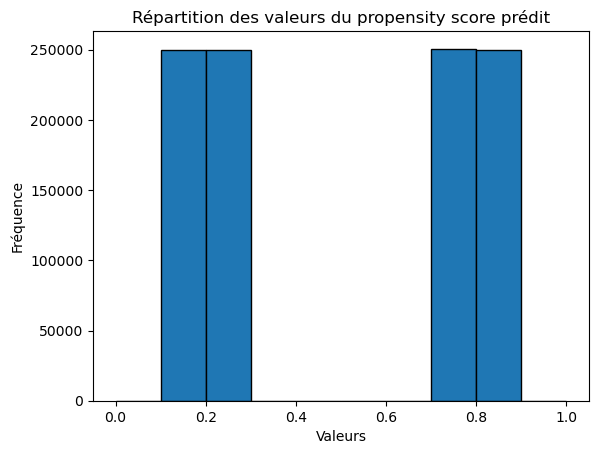

In [146]:
print('tau_pf = E[Y,Z=1] - E[Y,Z=0] =', round(tau_pf,ndigits=3))   
print('tau_causal = E[Y(1)] - E[Y(0)] =', round(tau_causal ,ndigits=3))
tau_est2 = regLogY(df)
tau_est3 = regArbY(df)
tau_est4, e_pred = regLogE(df)
print("tau_estimé (OR reg. log.) =", round(tau_est2, 3))
print("tau_estimé (OR arb. dec.) =", round(tau_est3, 3))
print("tau_estimé (IPW reg.log.) =", round(tau_est4, 3))

# Tracer l'histogramme propensity score
plt.hist(e_pred, bins=10, edgecolor='black', range=(0, 1))  # 'bins' définit le nombre de bacs dans l'histogramme

# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Répartition des valeurs du propensity score prédit')

# Afficher l'histogramme
plt.show()